In [1]:
# required imports

import random
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import islice
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# do not show warning for division by 0
_ = np.seterr(divide='ignore', invalid='ignore')

In [2]:
# import dataset and display it

data = pd.read_csv('data.csv', encoding='cp1252').drop('Index', axis=1)
original_size = len(data)

data

Title                    Artist            Top Genre  \
0                    Sunrise               Norah Jones      adult standards   
1                Black Night               Deep Purple           album rock   
2             Clint Eastwood                  Gorillaz  alternative hip hop   
3              The Pretender              Foo Fighters    alternative metal   
4     Waitin' On A Sunny Day         Bruce Springsteen         classic rock   
...                      ...                       ...                  ...   
1989        Heartbreak Hotel             Elvis Presley      adult standards   
1990               Hound Dog             Elvis Presley      adult standards   
1991         Johnny B. Goode               Chuck Berry           blues rock   
1992               Take Five  The Dave Brubeck Quartet                bebop   
1993          Blueberry Hill               Fats Domino      adult standards   

      Year  Beats Per Minute (BPM)  Energy  Danceability  Loudness (dB)  \
0     2004                     157      30            53            -14   
1     2000                     135      79            50            -11   
2     2001                     168      69            66             -9   
3     2007                     173      96            43             -4   
4     2002                     106      82            58             -5   
...    ...                     ...     ...           ...            ...   
1989  1958                      94      21            70            -12   
1990  1958                     175      76            36             -8   
1991  1959                     168      80            53             -9   
1992  1959                     174      26            45            -13   
1993  1959                     133      50            49            -10   

      Liveness  Valence Length (Duration)  Acousticness  Speechiness  \
0           11       68               201            94            3   
1           17       81               207            17            7   
2            7       52               341             2           17   
3            3       37               269             0            4   
4           10       87               256             1            3   
...        ...      ...               ...           ...          ...   
1989        11       72               128            84            7   
1990        76       95               136            73            6   
1991        31       97               162            74            7   
1992         7       60               324            54            4   
1993        16       83               148            74            3   

      Popularity  
0             71  
1             39  
2             69  
3             76  
4             59  
...          ...  
1989          63  
1990          69  
1991          74  
1992          65  
1993          56  

[1994 rows x 14 columns]

The following features from the dataset will be used for clustering:

1 - Beats Per Minute (BPM)
2 - Energy
3 - Danceability
4 - Loudness (dB)
5 - Liveness
6 - Valence
7 - Acousticness
8 - Speechiness


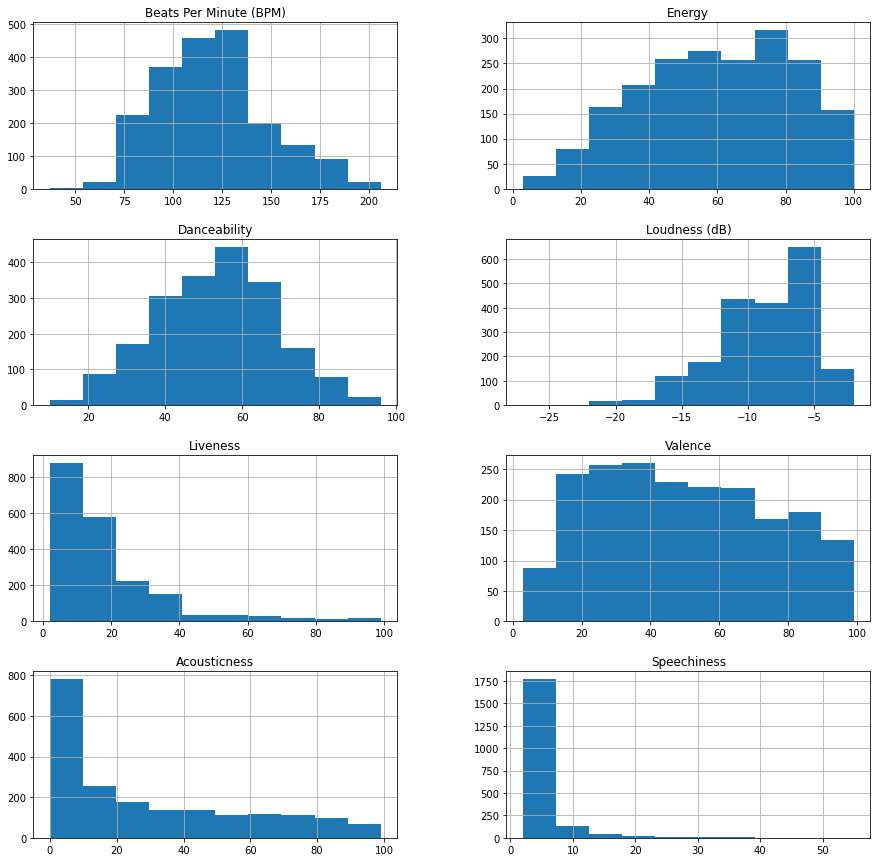

In [3]:
# extract audio features relevant to clustering and display them with their distribution

features = list(data.columns[4:13])
del features[6]

print('The following features from the dataset will be used for clustering:\n')

for i, feature in enumerate(features):
    print(f'{i + 1} - {feature}')
    
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
fig = data.hist(column=features, ax=axes)

In [4]:
# extract the genres and display them

def get_genres():
    return sorted(data['Top Genre'].unique(), reverse = True, 
                  key = lambda genre: len(data.loc[data['Top Genre'] == genre]))

def display_genres():
    genres = get_genres()
    
    print(f'Displaying {len(genres)} genres.\n')
    
    longest_length = len(max(genres, key = len))
    
    print(f'{"idx":{3}} | {"genres":^{longest_length}} | {"# entries":^{3}}\n' + '-' * (longest_length + 18))
    
    for i, genre in enumerate(genres):
        num = len(data.loc[data['Top Genre'] == genre])
        print(f'{i + 1:<{3}} | {genre:{longest_length}} | {num:<{9}}')
    
display_genres()

Displaying 149 genres.

idx |           genres            | # entries
---------------------------------------------
1   | album rock                  | 413      
2   | adult standards             | 123      
3   | dutch pop                   | 88       
4   | alternative rock            | 86       
5   | dance pop                   | 83       
6   | dutch indie                 | 75       
7   | alternative metal           | 70       
8   | dance rock                  | 52       
9   | classic rock                | 51       
10  | dutch cabaret               | 51       
11  | modern rock                 | 49       
12  | glam rock                   | 49       
13  | pop                         | 47       
14  | art rock                    | 40       
15  | permanent wave              | 38       
16  | british invasion            | 36       
17  | irish rock                  | 34       
18  | british soul                | 31       
19  | europop                     | 27       
20  | clas

In [5]:
# 149 genres leads to too many clusters. we reduce this number in two ways:
# 1: group similar genres together (ie: 'album rock' and 'alternative rock' are grouped under 'rock')
# 2: only pick the most represented genres in the dataset

# 1
def group_genres(groups):
    for group in groups:
        data.loc[[group in genre for genre in data['Top Genre']], 'Top Genre'] = group

group_genres(['rock', 'pop', 'indie', 'hip hop', 'soul', 'metal', 'country', 'folk', 'jazz', 'elec', 'dance'])

# 2 (only keep genres with more than 20 songs)
top_genres = [genre for genre in get_genres() if len(data.loc[data['Top Genre'] == genre]) > 20]
data = data[data['Top Genre'].isin(top_genres)]

display_genres()

print(f'\nThe dataset now has {len(data)} entries.\n{original_size - len(data)} entries were removed, ' +
       'keeping only songs that belong in a genre with 10 or more songs. ')

data

Displaying 10 genres.

idx |      genres      | # entries
----------------------------------
1   | rock             | 857      
2   | pop              | 388      
3   | adult standards  | 123      
4   | metal            | 93       
5   | indie            | 79       
6   | dutch cabaret    | 51       
7   | soul             | 45       
8   | permanent wave   | 38       
9   | british invasion | 36       
10  | hip hop          | 29       

The dataset now has 1739 entries.
255 entries were removed, keeping only songs that belong in a genre with 10 or more songs. 


Title             Artist        Top Genre  Year  \
0                    Sunrise        Norah Jones  adult standards  2004   
1                Black Night        Deep Purple             rock  2000   
2             Clint Eastwood           Gorillaz          hip hop  2001   
3              The Pretender       Foo Fighters            metal  2007   
4     Waitin' On A Sunny Day  Bruce Springsteen             rock  2002   
...                      ...                ...              ...   ...   
1988              Summertime    Louis Armstrong  adult standards  1958   
1989        Heartbreak Hotel      Elvis Presley  adult standards  1958   
1990               Hound Dog      Elvis Presley  adult standards  1958   
1991         Johnny B. Goode        Chuck Berry             rock  1959   
1993          Blueberry Hill        Fats Domino  adult standards  1959   

      Beats Per Minute (BPM)  Energy  Danceability  Loudness (dB)  Liveness  \
0                        157      30            53            -14        11   
1                        135      79            50            -11        17   
2                        168      69            66             -9         7   
3                        173      96            43             -4         3   
4                        106      82            58             -5        10   
...                      ...     ...           ...            ...       ...   
1988                     168       7            17            -21        14   
1989                      94      21            70            -12        11   
1990                     175      76            36             -8        76   
1991                     168      80            53             -9        31   
1993                     133      50            49            -10        16   

      Valence Length (Duration)  Acousticness  Speechiness  Popularity  
0          68               201            94            3          71  
1          81               207            17            7          39  
2          52               341             2           17          69  
3          37               269             0            4          76  
4          87               256             1            3          59  
...       ...               ...           ...          ...         ...  
1988       10               298            92            3          66  
1989       72               128            84            7          63  
1990       95               136            73            6          69  
1991       97               162            74            7          74  
1993       83               148            74            3          56  

[1739 rows x 14 columns]

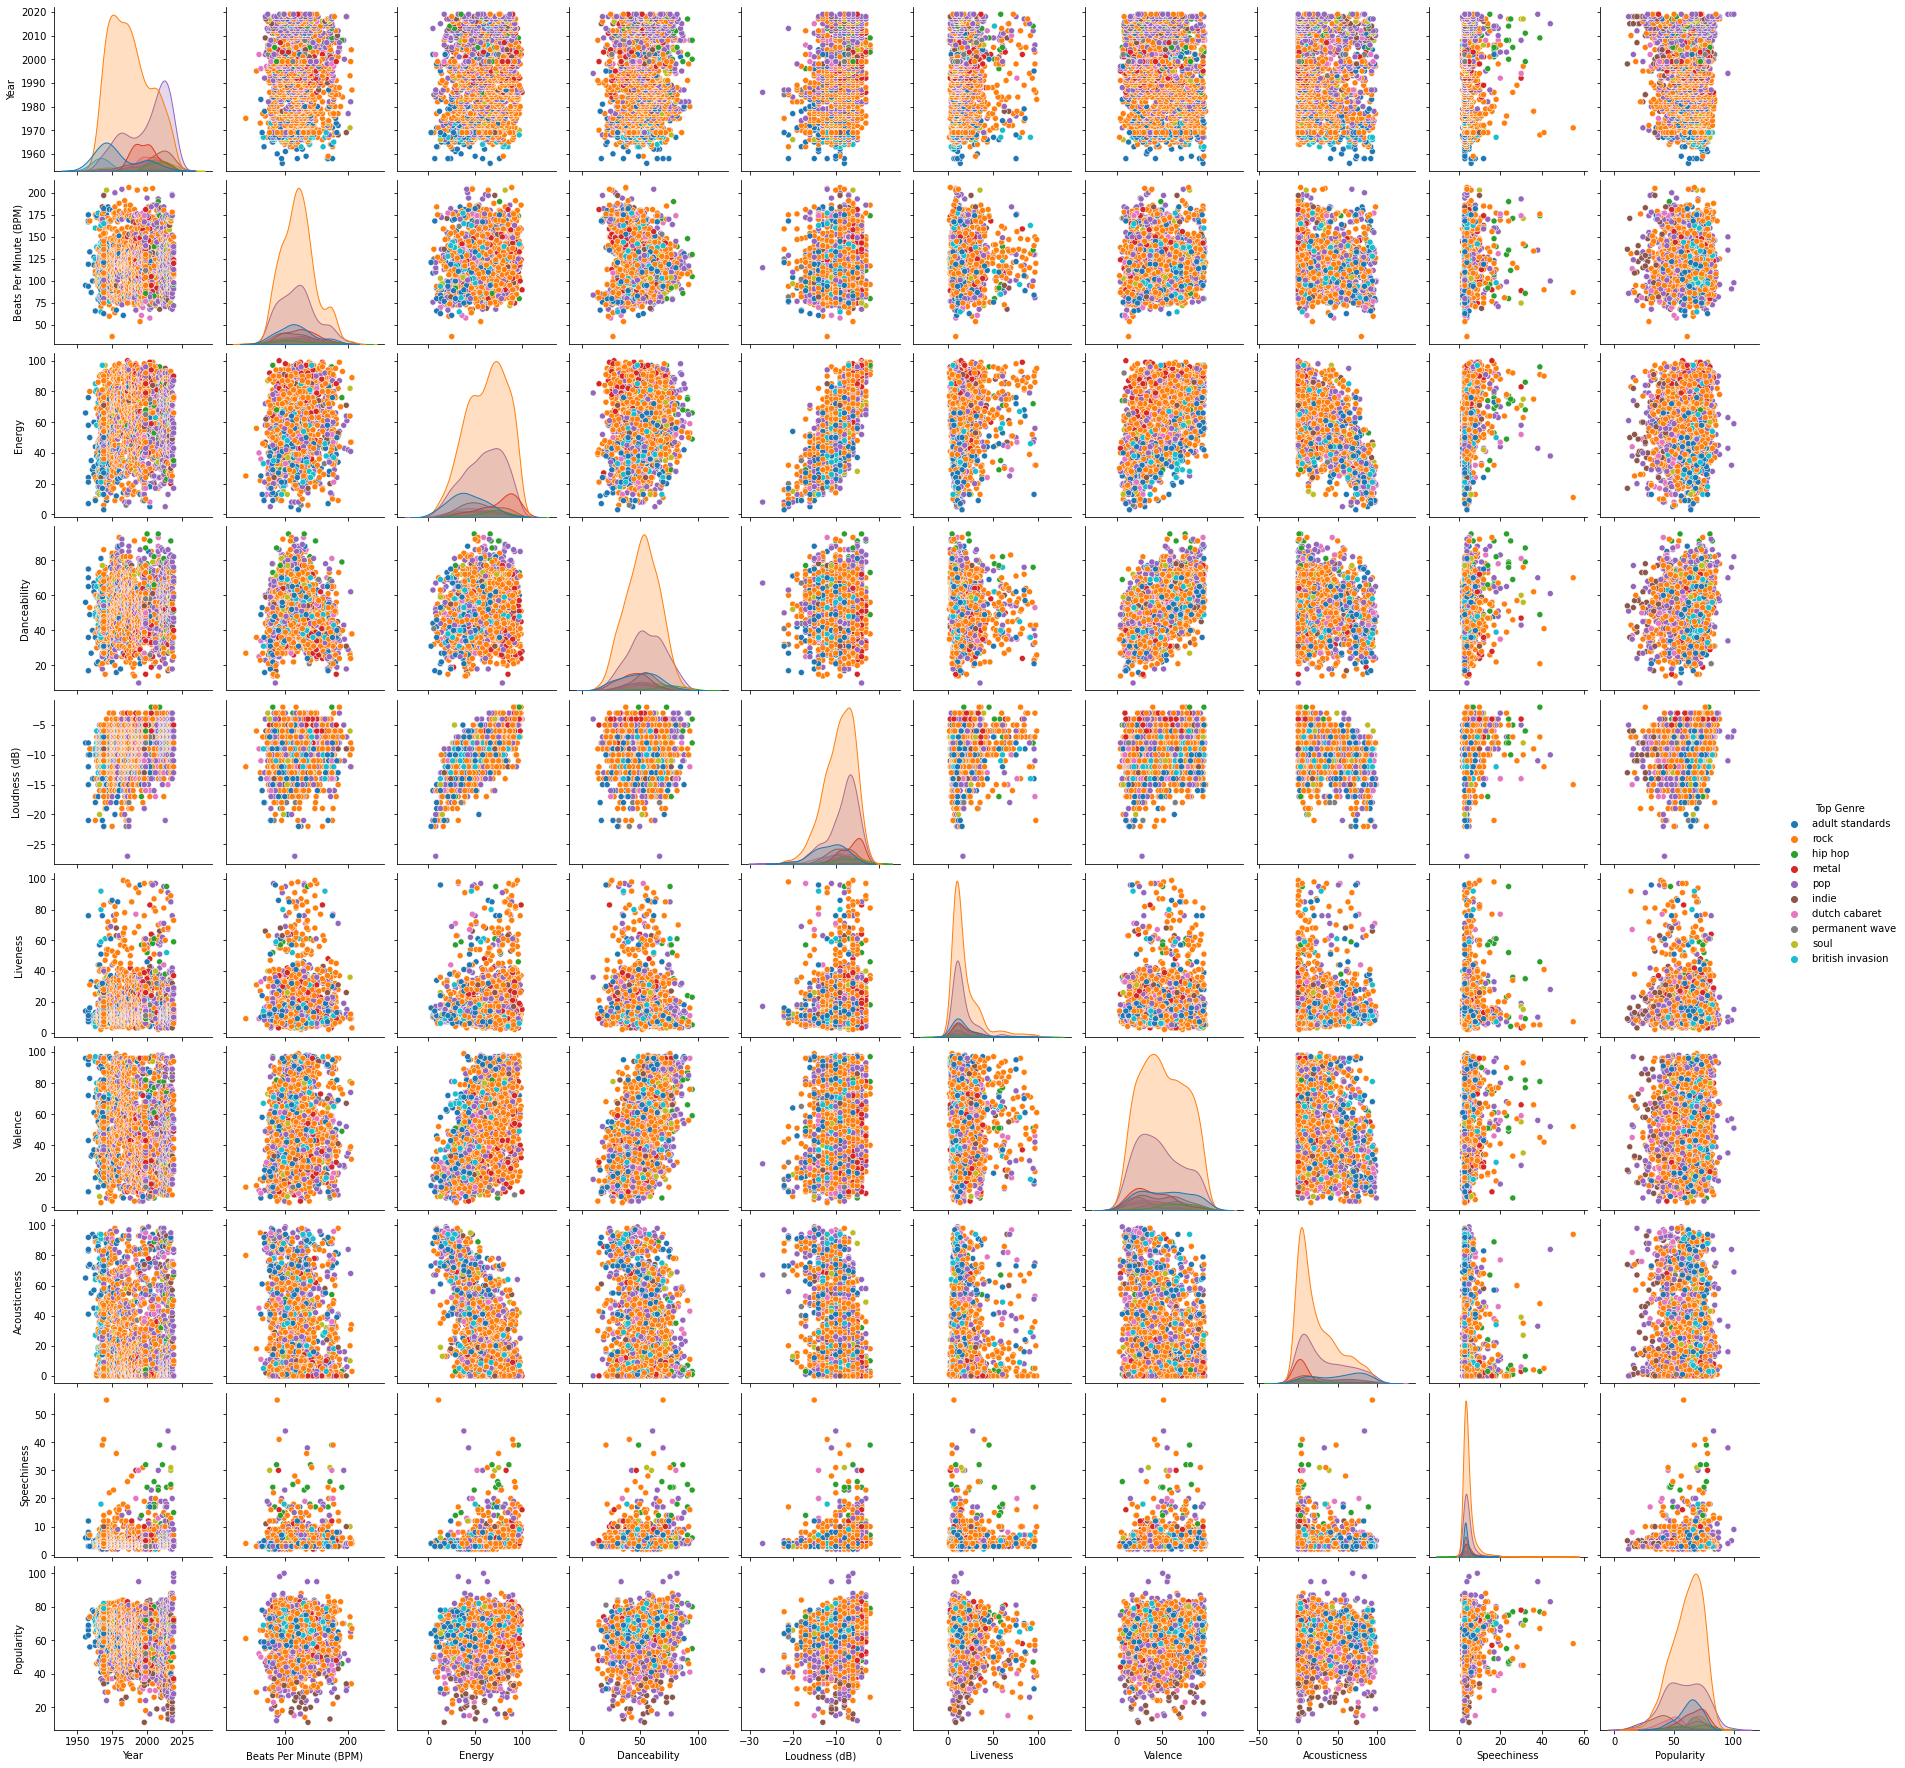

In [17]:
sns.pairplot(data, hue = 'Top Genre') 

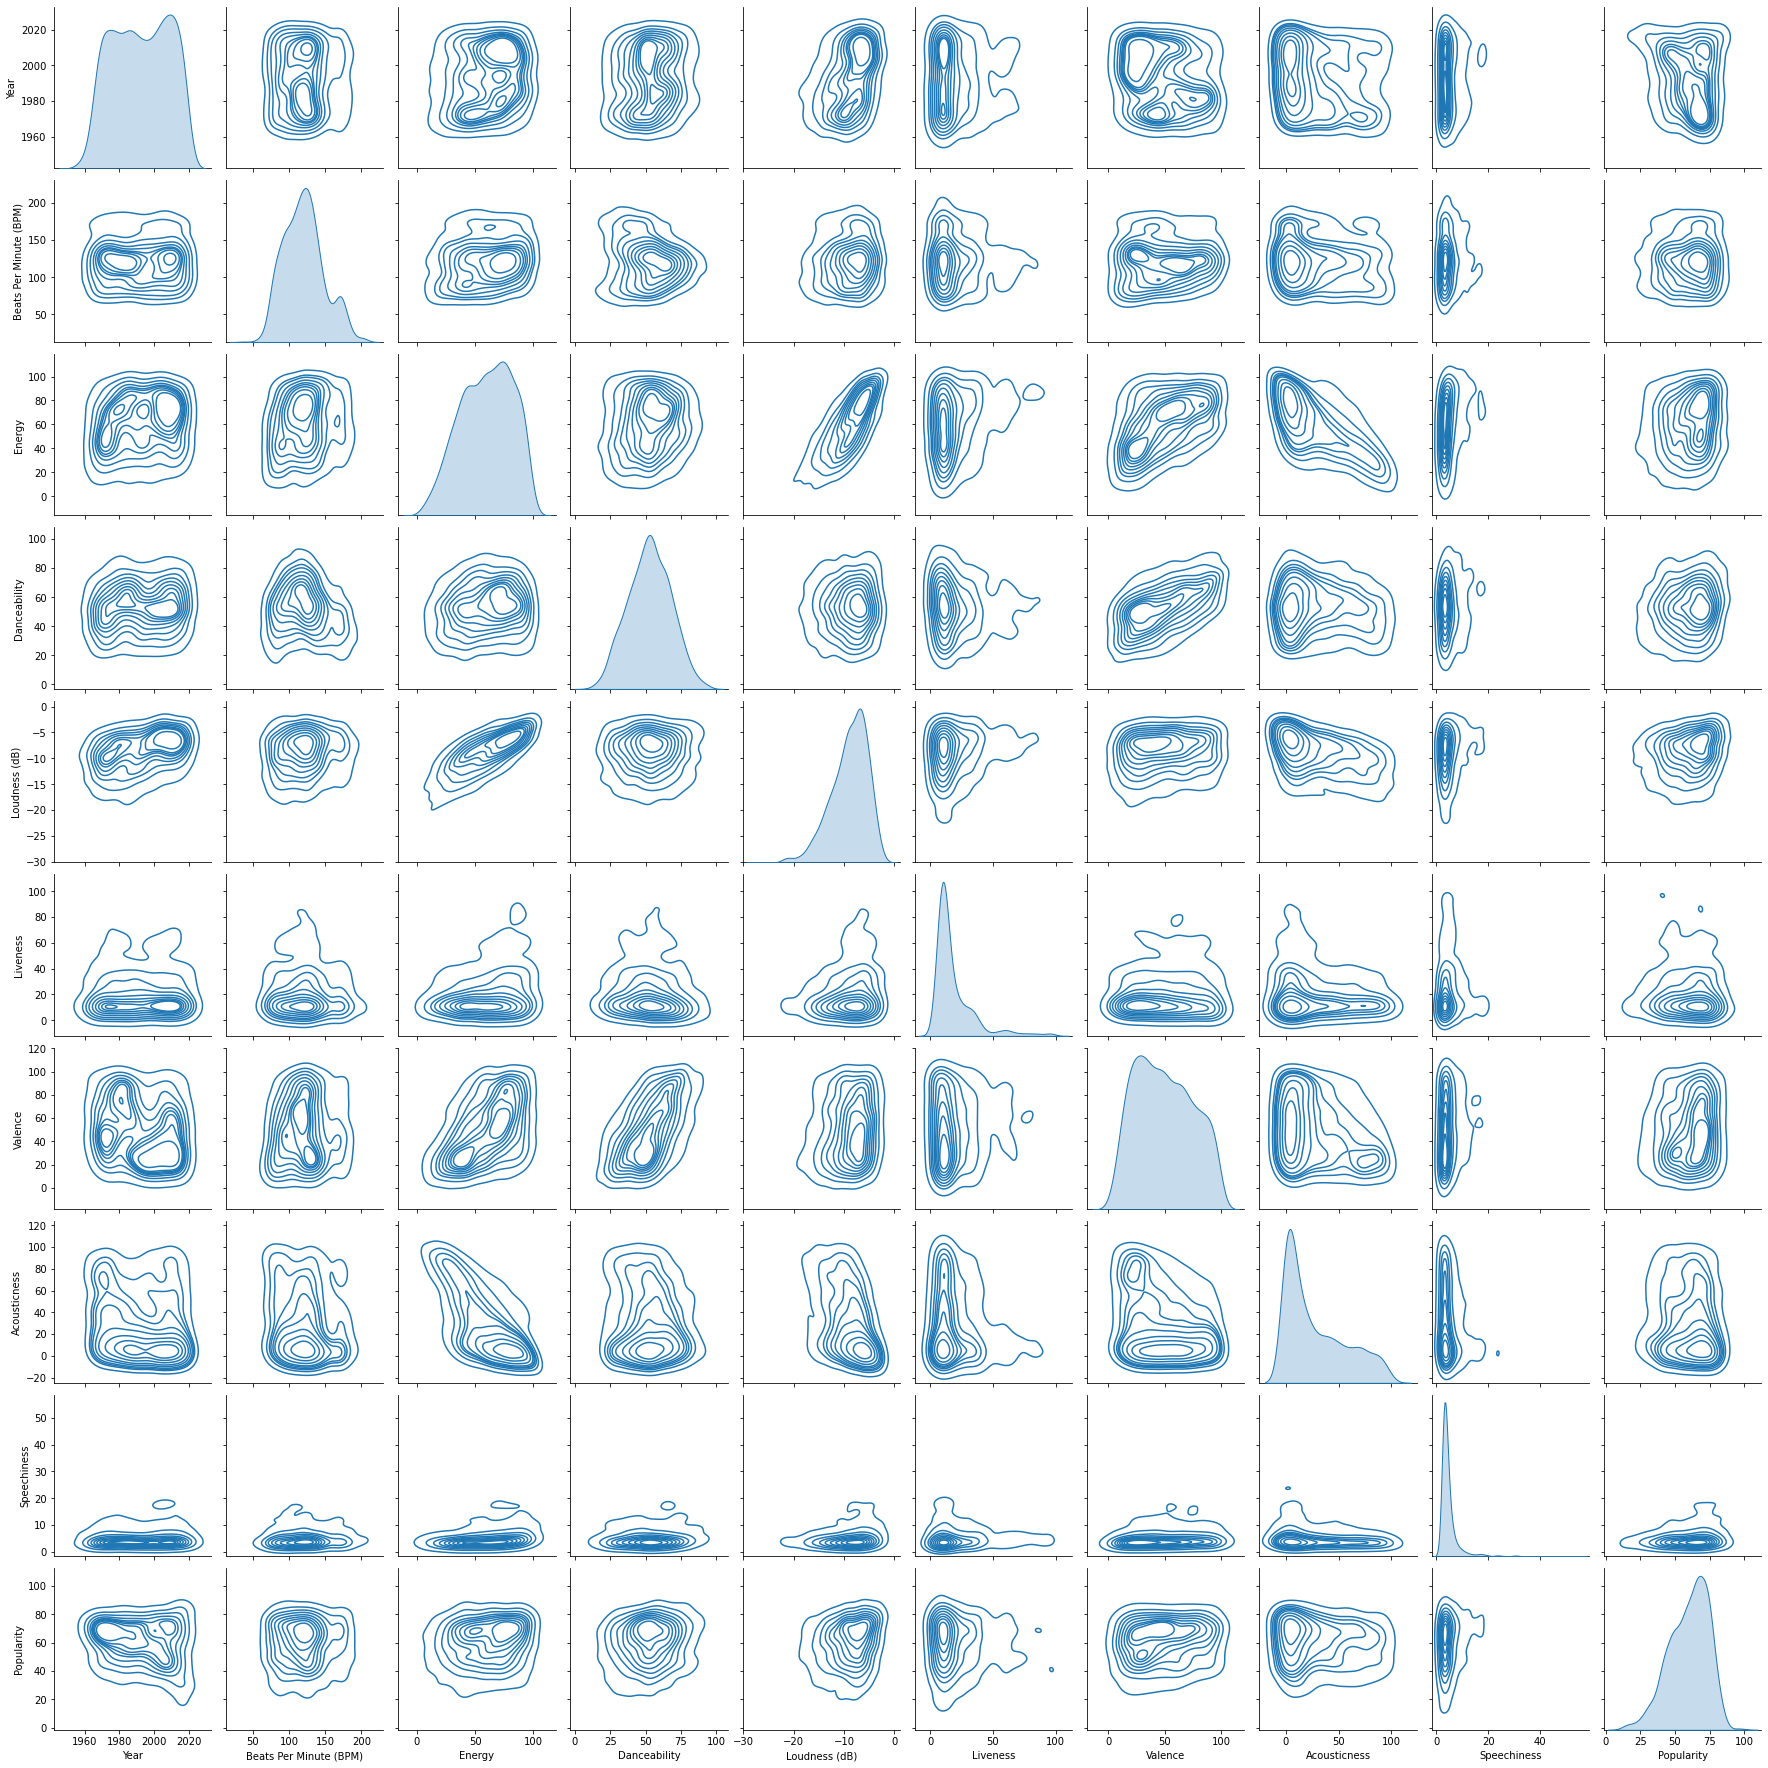

In [18]:
sns.pairplot(data, kind="kde")


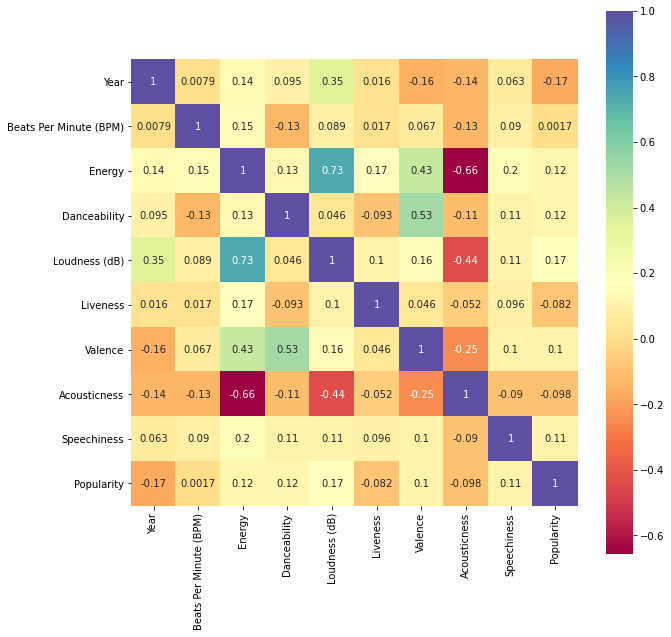

In [21]:
plt.figure(figsize=(10,10))
corrmat = data.corr()
sns.heatmap(corrmat, annot = True, square = True, cmap = 'Spectral')
plt.show()

In [48]:
from sklearn.mixture import GaussianMixture 
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA